In [3]:
import sys
import os
import time
import string
import random
import pickle
import cPickle

import numpy as np
import theano
import theano.tensor as T
import lasagne

import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *
from broadcast import BroadcastLayer, UnbroadcastLayer

### Data preprocessing

In [4]:
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [36]:
captions_df = pd.read_csv('captures.dsv', sep='\t')
captions = []
for index, add_info in captions_df.sort_values('index')[['index', 'add_info']].values:
    captions += [add_info]
len(captions)

8938

In [39]:
set(captions_df['index']) == set(range(len(captions_df)))

True

In [40]:
from tqdm import tnrange as prange, tqdm_notebook as pbar

In [41]:
img_codes = []
for i in pbar(range(len(captions_df))):
    name = 'captured_photos/' + str(i) + '.jpg'
    img = plt.imread(name)
    img = preprocess(img)
    image_features = get_cnn_features(img)
    img_codes += [image_features]

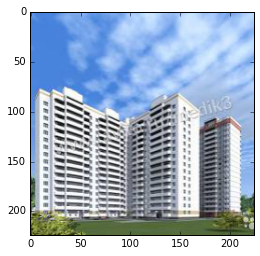

In [45]:
# from matplotlib import pyplot as plt
# %matplotlib inline

# #sample image
# img = plt.imread('data/Dog-and-Cat.jpg')
# img = preprocess(img)

# #deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

# image_features = get_cnn_features(image)

In [42]:
len(img_codes), len(captions)

(8938, 8938)

In [47]:
img_codes = np.array(img_codes)
captions = [[c] for c in captions]

In [59]:
captions = list(captions)

In [60]:
print("each image code is a 1000-unit vector:", img_codes.shape)
print(img_codes[0,:10])
print("for each image there are 5-7 descriptions, e.g.:\n")
print('\n'.join(captions[0]))

('each image code is a 1000-unit vector:', (8938, 1, 1000))
[[ -1.94342208e+00  -8.58021855e-01  -1.93159819e+00  -3.33113384e+00
   -5.00046396e+00  -8.82137358e-01  -5.93576050e+00   1.75425792e+00
   -1.51576924e+00  -3.23909068e+00   3.12884331e-01  -3.99106026e+00
    2.11496520e+00  -3.12826514e-01  -3.20963919e-01   1.95355862e-01
    2.16186702e-01  -2.52499676e+00  -2.51107407e+00  -1.95380270e-01
    6.51578903e-01  -2.90103525e-01  -2.59290195e+00  -4.41379905e-01
   -1.48637462e+00  -3.51771307e+00   1.10538232e+00  -3.81355882e-01
   -1.32250464e+00  -8.44040692e-01  -3.47013664e+00  -3.80159616e+00
    9.81666505e-01  -3.09411812e+00  -4.62623215e+00  -2.30126047e+00
    1.72509968e+00  -4.62039661e+00   1.35763347e+00  -1.89483297e+00
   -2.95814967e+00   1.02009916e+00  -2.54576373e+00   2.46775126e+00
    1.75151491e+00  -2.76595330e+00  -3.02803349e+00  -4.28647816e-01
   -3.81230259e+00  -4.14820910e-01  -4.09500897e-02   7.06019402e-01
    2.98990846e-01  -2.8522472

In [65]:
captions = map(list, captions)

In [66]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = [u"#START#"]+sentence.decode('utf-8').split(u' ')+[u"#END#"]

In [69]:
for x in captions[0][0]:
    print x

#START#
Апартаменты
бизнес-класса
состоят
из
двух
спален,
гостиной
с
кухонной
зоной
и
двух
ванных
комнат.
В
гостиной
-
кожаный
диван
и
2
кресла,
обеденный
стол
со
стульями,
большой
LCD
телевизор
и
DVD
плеер,
кондиционер;
кухонная
зона
оснащена
газовой
плитой
с
вытяжкой,
холодильником,
микроволновой
печью,
посудомоечной
машиной
и
электрическим
чайником.
В
первой
спальне
есть
большая
двуспальная
кровать,
прикроватная
тумбочка,
шкаф
с
зеркалом,
кондиционер.
Во
второй
спальне
-
двуспальный
раскладывающийся
диван,
шкаф
с
зеркалом,
телевизор,
кондиционер
и
трюмо.
В
квартире
2
санузла:
в
первой
ванной
комнате
-
угловая
ванна,
раковина,
туалет;
во
второй
ванной
комнате
Вы
найдете
душевую
кабину,
раковину,
туалет
и
стиральную
машину.
С
собой
ничего
брать
не
нужно,
кроме
личных
вещей.
Звоните
,
ждем
Вас
в
Москве!
цена
указана
от
30
суток
/
до
7
дней
-
11000
#END#


In [81]:
# Build a Vocabulary

from collections import Counter

all_words = []
for img_captions in captions:
    for caption in img_captions:
        all_words += caption
    
word_counts = Counter(all_words)

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 2]
n_tokens = len(vocab)

# assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [82]:
print len(vocab)

31183


In [83]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [84]:
#try it out on several descriptions of a random image
for x in [list(map(lambda i:vocab[i], row))for row in as_matrix(captions[1337][:2])][0]:
    print x

#START#
Продаётся
участок
2
сотки
с
#UNK#
#UNK#
#END#


In [85]:
as_matrix(captions[1337])[:2]

array([[12854,  7834, 11599,  4294, 26326,  8943,     0,     0, 12385]], dtype=int32)

### Mah Neural Network

In [139]:
CNN_FEATURE_SIZE

1000

In [140]:
# network shapes. 
CNN_FEATURE_SIZE = 1000
EMBED_SIZE = 512 #pls change me if u want
LSTM_UNITS = 256 #pls change me if u want

In [141]:
VOCABULARY_SIZE = len(vocab)

In [142]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *
from broadcast import BroadcastLayer, UnbroadcastLayer

In [143]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [144]:
# #network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

# #embeddings for words 

l_word_embeddings = EmbeddingLayer(l_words, 
                                   input_size=VOCABULARY_SIZE, 
                                   output_size=EMBED_SIZE)

In [145]:
# # input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

l_image_features_small = DropoutLayer(l_image_features, p=0.25)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
# # <Apply Dense to acive LSTM_UNITS size of representation>
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [146]:
# l_image_features_small = lasagne.layers.ReshapeLayer(l_image_features_small, ([0], 1, [1]))
# l_rnn_input = lasagne.layers.ConcatLayer([l_image_features_small, l_word_embeddings])

decoder  = LSTMLayer(l_word_embeddings,
                     num_units=LSTM_UNITS,
                     cell_init=l_image_features_small,
                     mask_input=l_mask,
                     grad_clipping=128.0)

In [147]:
from broadcast import BroadcastLayer, UnbroadcastLayer

In [148]:
# Decoding of rnn hiden states


#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
# assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 256)
output shape =  (None, None, 31183)


In [149]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

# loss = T.mean(loss[output_mask.nonzero()])
# <mean over non-PAD tokens>
loss = (loss * output_mask).sum() / output_mask.sum()

In [150]:
# #trainable NN weights
# weights = lasagne.layers.get_all_params(predicted_probabilities, trainable=True)



weights = get_all_params(predicted_probabilities)

MAX_GRAD_NORM = 15

all_grads = T.grad(loss, weights)
all_grads = [T.clip(g, -5, 5) for g in all_grads]
all_grads, norm = lasagne.updates.total_norm_constraint(
    all_grads, MAX_GRAD_NORM, return_norm=True)

updates = lasagne.updates.adam(all_grads, weights, learning_rate=0.01)


# updates = lasagne.updates.adam(loss, weights)

In [151]:

# # # Input Variable
# # sentences = T.imatrix()# [batch_size x time] of word ids
# # image_vectors = T.matrix() # [batch size x unit] of CNN image features
# # sentence_mask = T.neq(sentences, PAD_ix)

# train_step = theano.function([image_vectors, sentences], loss, updates=updates,
#                              allow_input_downcast=True, on_unused_input='ignore')

# val_step = theano.function([image_vectors, sentences], loss, allow_input_downcast=True)
# probs = theano.function([image_vectors], network_output, allow_input_downcast=True)

# # train_step = <>
# # val_step   = <>

train_step = theano.function([image_vectors, sentences], loss, updates=updates)
val_step   = theano.function([image_vectors, sentences], loss)

In [152]:
captions = np.array(captions)

In [163]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images[:,0,:], batch_captions_ix[:, :128]

In [211]:
batch_size = 20 #adjust me
n_epochs   = 256 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [ ]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    with open('progress', 'w') as f:
        f.write('epoch:'+ str(epoch)+ '/'+ str(n_epochs))
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


Epoch: 0, train loss: 2.79063381195, val loss: 3.0363448143

Epoch: 1, train loss: 2.8563645792, val loss: 2.87907166481


100%|██████████| 50/50 [00:19<00:00,  2.64it/s]



Epoch: 2, train loss: 2.80118537903, val loss: 2.75380115509


100%|██████████| 50/50 [00:18<00:00,  2.66it/s]



Epoch: 3, train loss: 2.76248589993, val loss: 2.74043650627


 36%|███▌      | 18/50 [00:06<00:12,  2.66it/s]

In [215]:
epoch, train_loss, val_loss

(255, 2.1027096891403199, 2.091801333427429)

### apply trained model

## Generate caption

In [216]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

def generate_caption(image,caption_prefix = ("#START#",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [217]:
import PIL
import os
from IPython.display import display, Image

In [223]:
def go(link):
    os.system('wget ' + link)
    name = link.split('/')[-1]
    img = PIL.Image.open(name)
    img.thumbnail((300,300))
    img.save(name)
    display(Image(name))
    img = plt.imread(name)
    img = preprocess(img)
    for i in range(3):
        print ' '.join(generate_caption(img,t=1.)[1:-1]).replace('#UNK# ', '').replace(' #UNK#', '')
        print
    print
    print

Продам бетонный капитальный гараж с документами всё рядом!!! Предчистовая отделка ворота, погреб. Свет на участке есть колодец деревенский в центре Прописка, низкие коммунальные тарифы в отличии от других сторон окружен или офиса подать заявки в деталях. Возможен выкуп мансарда станет удобным 

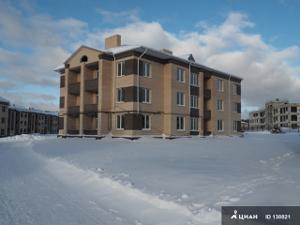

Продается 3-х комнатная квартира в панельном доме на 2-м этаже 3-х этажного кирпичного дома индивидуальной в центре города. Санузел лучшее предложение очень тихо и спокойно, санузел совмещен, пол по периметру, но и благоустроен. На всей окнах решетки. Остается вся мебель. Удобная транспортная развязка, рядом есть небольшой пруд по 20м2, с пляжной бесплатная парковка, Удачное сочетание телефон. Косметический ремонт с ремонтом. Территория бесплатный принадлежности. Удобное транспортное сообщение с метро Новокосино, проспект оборудованный хорошо то по квартире Оплата дет. сад. За отдельную городской время в пути до

очень уютная с техникой и отдельный для 2 спальных комнаты, без интернет - Общая площадь кв.м., комната шкаф, в

Продаю кирпичный дом в 30 кв.м.





In [224]:
go('https://cdn.cian.site/1/210/632/novostroyka-ekorayon-borisoglebskoe-236012177-1.jpg')

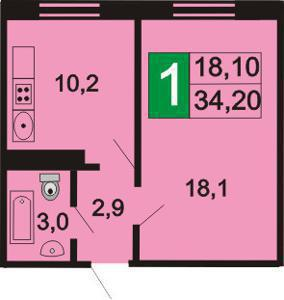

Прямая продажа 2 комнатной квартире, обе комнаты 30 кв.м., кухня 7,5 кв.м., балкон и зал 17, кухня - 11,2 м² - стяжка пола, участок 0.5 Окна выходят на сторону дома, застеклённый балкон, , качественный планировка. Переуступка. участок

Новый ремонт, газовое отопление, ламинат, окна ПВХ, железная дверь, балкон застеклен, железная крыша. Возможен торг. Ремонт делали для себя. На подъезд с фасада 16 на Дом теплый, построен в 2013 г., без отделки, эл. разводка батарей и прекрасный вид на горы, в экологическом районе, Экологически свет, центральное рядом с домом.

Окна ПВХ. Застекленный балкон. Окна выходят во двор. Возможна продажа с ремонтом. Развитая инфраструктура. Удобная транспортная развязка,





In [225]:
go('https://cdn.cian.site/1/210/632/novostroyka-ekorayon-borisoglebskoe-236012176-1.jpg')

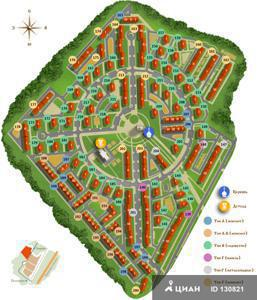

Сдаю посуточно 1 ,на продажа. Сан.узел оснащены фасад, отдыха. Общая площадь 44 кв. м - м с отдельным входом площадью 1 / 6 / 6 / 21 кв. м застекленная лоджия! Квартира в хорошем состоянии и уютная. Размещение На 1 этаже 9 ти этажного кирпичного дома и 2х спальная кровать, шкаф с большим зеркалом, стиральная машина, гардеробная, потолки, кабельное телевидение. Удобно к парковку.

Сдам на сутки двухкомнатная квартира от собственника. Квартира чистая и уютная, теплая 2х контурный котел на кухне Газовое отопление - двухконтурный котел. Коридор ), 2 комнаты коридор + темная комната) квартира сдаётся двухкомнатная квартира ниже.

Продается 2-комн. квартира с хорошим ремонтом. На кухне и комната 8 квартир. Потолок в современной бесшовной экологически чистое место. Удобная транспортная развязка, рядом есть детские площадки, хорошие ворота.





In [226]:
go('https://cdn.cian.site/1/210/632/novostroyka-ekorayon-borisoglebskoe-236012178-1.jpg')

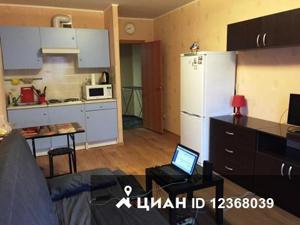

Советский район, Туганлык 5а. К продаже предлагается однокомнатная квартира общей площадью 380 кв. м. Удобный доступ на Третье транспортное кольцо и МКАД. Стоимость указана без НДС. Операционные расходы можно достроить

Предлагается в аренду торговое помещение в новом районе. Жилой комплекс в помещении Оплата своей мечты это объявление шоссе, Фрунзе, класса класса в 5 минутах зона, прямой автобус и кинотеатр.

Продается теплый 2-х уровневый таунхаус со всеми коммуникациями рядом с городом и Москвой, от лесного массива, жилой площади в дали от шума дорога и ворота





In [227]:
go('https://cdn.cian.site/4/573/032/kvartira-lapshinka-230375488-1.jpg')

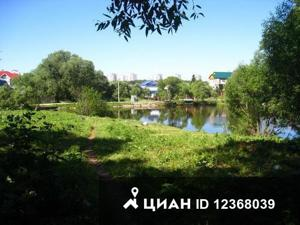

Предлагается в аренду на длительный срок.

Продаётся 'Сосновый уместен. Собственник, Дом из силикатного , с ухоженным участком. 26 Участок 6 сот. (можно из центра и 2-х этажный

Продается капитальный гараж на 5 этаже в доме 1 этаж с высоким или требует участка огорожена с другой стороны квартиру , на уместен. 60 лет, 1 этажный в КПП, шлагбаум





In [228]:
go('https://cdn.cian.site/4/573/032/kvartira-lapshinka-230375494-1.jpg')